In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc
from postp import HARMONY

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

### load metadata

In [ ]:
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27me3'

df_mult_rna = pd.read_csv(join(data_dir, 'rna+H3K27me3/GSM6753044_MouseBrain_20um_100barcodes_H3K27me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+H3K27me3/peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values
ad_mult_atac.layers['counts'] = ad_mult_atac.X.copy()

ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

rna_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27ac/rna+atac'
# GSM6753045, GSM6204635, GSM6753042
df_rna = pd.read_csv(
    f'{rna_dir}/GSM6753045_MouseBrain_20um_100barcodes_H3K27ac_matrix.tsv', 
    sep='\t')

df_rna_spatial = pd.read_csv(
    f'{rna_dir}/GSM6753045_spatial/tissue_positions_list.csv', 
    header=None, index_col=0)
ad_rna = sc.AnnData(df_rna.T, obsm={'spatial': df_rna_spatial.loc[df_rna.columns, [2, 3]].values})
ad_rna.layers['counts'] = ad_rna.X.copy()

ad_atac = load_peak_expr(join(data_dir, 'H3K27me3/peak_data'))
df_atac_spatial = pd.read_csv(join(data_dir, 'H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_atac.obsm['spatial'] = df_atac_spatial.loc[ad_atac.obs_names, [2, 3]].values

shared_gene = ad_mult_rna.var_names.intersection(ad_rna.var_names)
ad_mult_rna = ad_mult_rna[:, shared_gene].copy()
ad_rna = ad_rna[:, shared_gene].copy()

shared_peak = ad_mult_atac.var_names.intersection(ad_atac.var_names)
ad_mult_atac = ad_mult_atac[:, shared_peak].copy()
ad_atac = ad_atac[:, shared_peak].copy()

ad_mult_rna.obs_names = [f'mult-{x}' for x in ad_mult_rna.obs_names]
ad_mult_atac.obs_names = [f'mult-{x}' for x in ad_mult_atac.obs_names]
ad_rna.obs_names = [f'rna-{x}' for x in ad_rna.obs_names]
ad_atac.obs_names = [f'atac-{x}' for x in ad_atac.obs_names]

ad_mult_rna.obs['src'] = ad_mult_atac.obs['src'] = ['mult']*ad_mult_rna.n_obs
ad_rna.obs['src'] = ['rna'] * ad_rna.n_obs
ad_atac.obs['src'] = ['atac'] * ad_atac.n_obs

ad_mult_rna.obsm['spatial'] = -1 * ad_mult_rna.obsm['spatial']
ad_mult_atac.obsm['spatial'] = -1 * ad_mult_atac.obsm['spatial']
ad_rna.obsm['spatial'] = -1 * ad_rna.obsm['spatial']
ad_atac.obsm['spatial'][:, 1] = -1 * ad_atac.obsm['spatial'][:, 1]

In [ ]:
df = pd.read_csv('./outputs/MB_RNA+H3K27me3.csv', index_col=0)

In [ ]:
ad_mult_rna.obsm['emb'] = df.loc[ad_mult_rna.obs_names].values
ad_rna.obsm['emb'] = df.loc[ad_rna.obs_names].values
ad_atac.obsm['emb'] = df.loc[ad_atac.obs_names].values

### before harmony

In [7]:
ad_mosaic = sc.concat([ad_mult_rna, ad_rna, ad_atac])
ad_mosaic = get_umap(ad_mosaic, ['emb'])

# try:
    
#     # from sklearn.cluster import KMeans
#     # print("mclust failed, try louvain")
#     # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb'])
#     # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     # clust_key = 'kmeans'

#     ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb')  
#     clust_key = 'mclust'
   
# except:

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb')  
#     # clust_key = 'mclust'
#     print('mclust failed')
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'
    
# split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs',  key=clust_key)
# ad_mosaic.obs['before_clust'] = ad_mosaic.obs[clust_key].to_list()

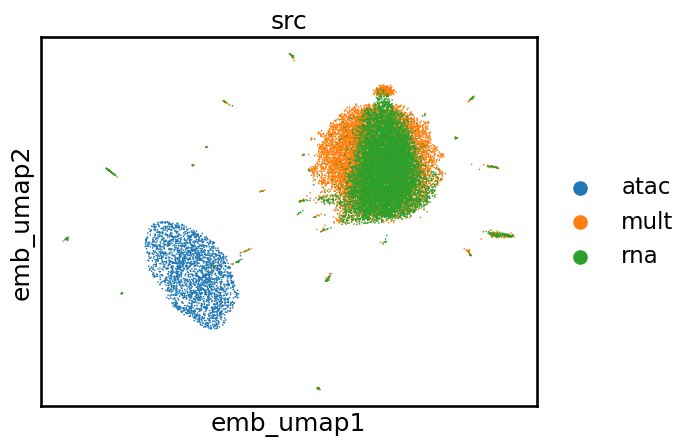

In [8]:
wrap_warn_plot(ad_mosaic, 'emb_umap', ['src'])

In [9]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

Chunk 968 does not have enough neighbors. Skipping...
Chunk 982 does not have enough neighbors. Skipping...
Chunk 1062 does not have enough neighbors. Skipping...
Chunk 1647 does not have enough neighbors. Skipping...
Chunk 1686 does not have enough neighbors. Skipping...
Chunk 1955 does not have enough neighbors. Skipping...
Chunk 2154 does not have enough neighbors. Skipping...
Chunk 2671 does not have enough neighbors. Skipping...
Chunk 2933 does not have enough neighbors. Skipping...
Chunk 5239 does not have enough neighbors. Skipping...
Chunk 8658 does not have enough neighbors. Skipping...
Chunk 9815 does not have enough neighbors. Skipping...
Chunk 9910 does not have enough neighbors. Skipping...
Chunk 10192 does not have enough neighbors. Skipping...
Chunk 11018 does not have enough neighbors. Skipping...
Chunk 11089 does not have enough neighbors. Skipping...
Chunk 11293 does not have enough neighbors. Skipping...
Chunk 11517 does not have enough neighbors. Skipping...
Chunk 1

0.34931654563051306

## after harmony

In [10]:
from postp import HARMONY

ad_mosaic.obsm['emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['emb']), ad_mosaic.obs['src'].values)
ad_mosaic = get_umap(ad_mosaic, ['emb_har'])
# split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obsm',  key='emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [11]:
# try:

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
#     # clust_key = 'mclust'
#     # mclust 跑不出来15个簇
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'
   
# except:

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
#     # clust_key = 'mclust'

#     from sklearn.cluster import KMeans
#     print("mclust failed, try kmeans")
#     kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'
    
# split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs',  key=clust_key)
# ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [12]:
### evaluation
from sklearn.metrics import adjusted_rand_score

lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]
r2

Chunk 13 does not have enough neighbors. Skipping...
Chunk 30 does not have enough neighbors. Skipping...
Chunk 324 does not have enough neighbors. Skipping...
Chunk 485 does not have enough neighbors. Skipping...
Chunk 601 does not have enough neighbors. Skipping...
Chunk 791 does not have enough neighbors. Skipping...
Chunk 1025 does not have enough neighbors. Skipping...
Chunk 1091 does not have enough neighbors. Skipping...
Chunk 1193 does not have enough neighbors. Skipping...
Chunk 1416 does not have enough neighbors. Skipping...
Chunk 1486 does not have enough neighbors. Skipping...
Chunk 1792 does not have enough neighbors. Skipping...
Chunk 1950 does not have enough neighbors. Skipping...
Chunk 2001 does not have enough neighbors. Skipping...
Chunk 2003 does not have enough neighbors. Skipping...
Chunk 2062 does not have enough neighbors. Skipping...
Chunk 2084 does not have enough neighbors. Skipping...
Chunk 2190 does not have enough neighbors. Skipping...
Chunk 2280 does no

0.320956426241634

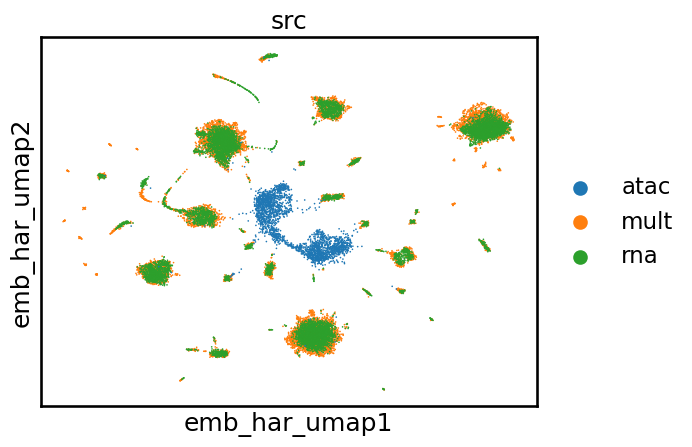

In [13]:
wrap_warn_plot(ad_mosaic, 'emb_har_umap', ['src'])

### Vis

In [14]:
# wrap_warn_plot(ad_mosaic, 'emb_umap', ['Sample'])

# # unify type colors
# mclust_type2dict = dict(zip(ad_mosaic.obs[clust_key].cat.categories, ad_mosaic.uns[f'{clust_key}_colors']))
# label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
# ad_bridge, ad_test_rna, ad_test_atac = unify_colors(
#     [ad_bridge, ad_test_rna, ad_test_atac], clust_key, mclust_type2dict)
# ad_bridge, ad_test_rna, ad_test_atac = unify_colors(
#     [ad_bridge, ad_test_rna, ad_test_atac], 'Combined_Clusters_annotation', label_type2dict)

In [15]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+H3K27me3/stabmap'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['emb'], index=ad_mult_rna.obs_names.to_list() + ad_rna.obs_names.to_list() + ad_atac.obs_names.to_list())
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['emb_har'], index=ad_mult_rna.obs_names.to_list() + ad_rna.obs_names.to_list() + ad_atac.obs_names.to_list())
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))